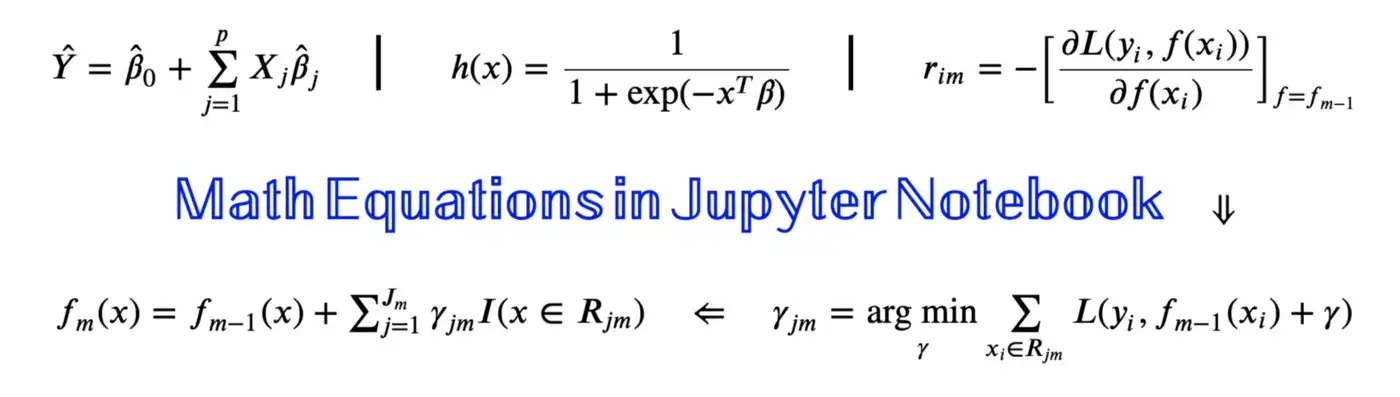

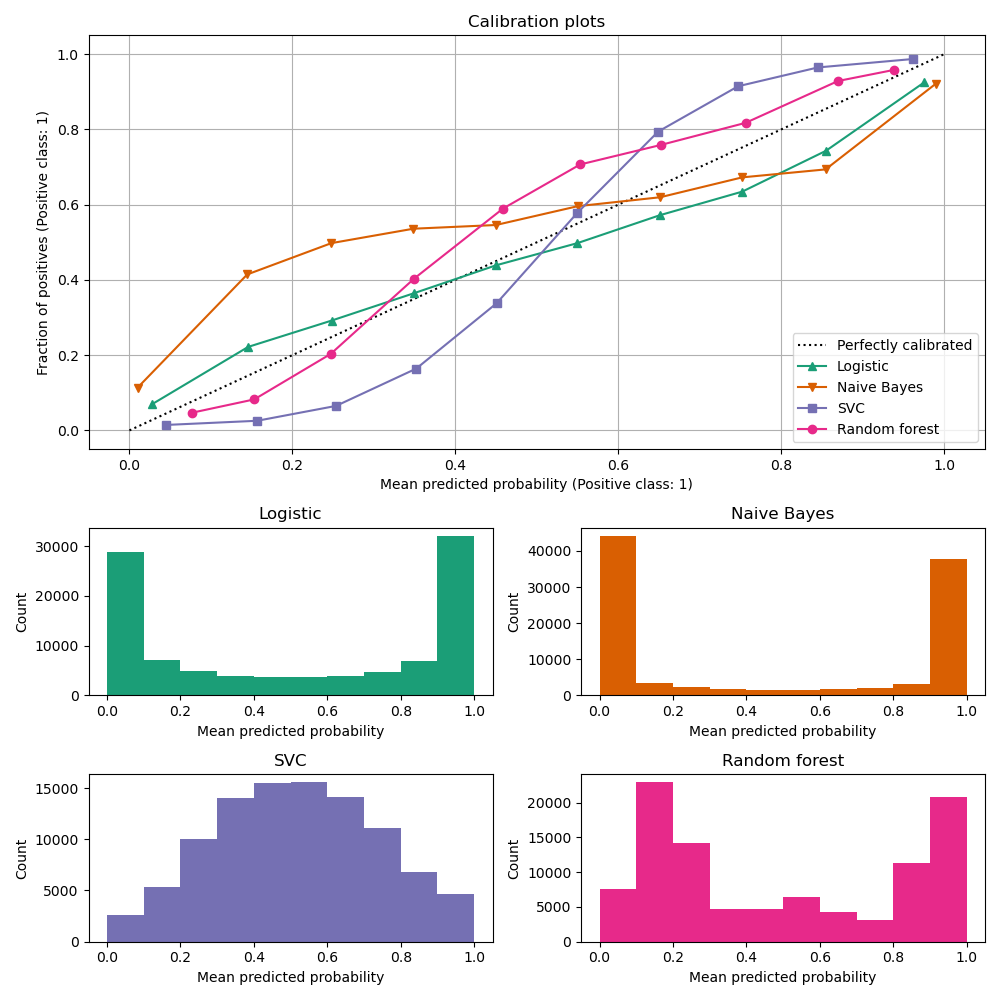

<strong>Content-Based Filtering: </strong>                                                                                                     <br>This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. <br>In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). <br>In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.

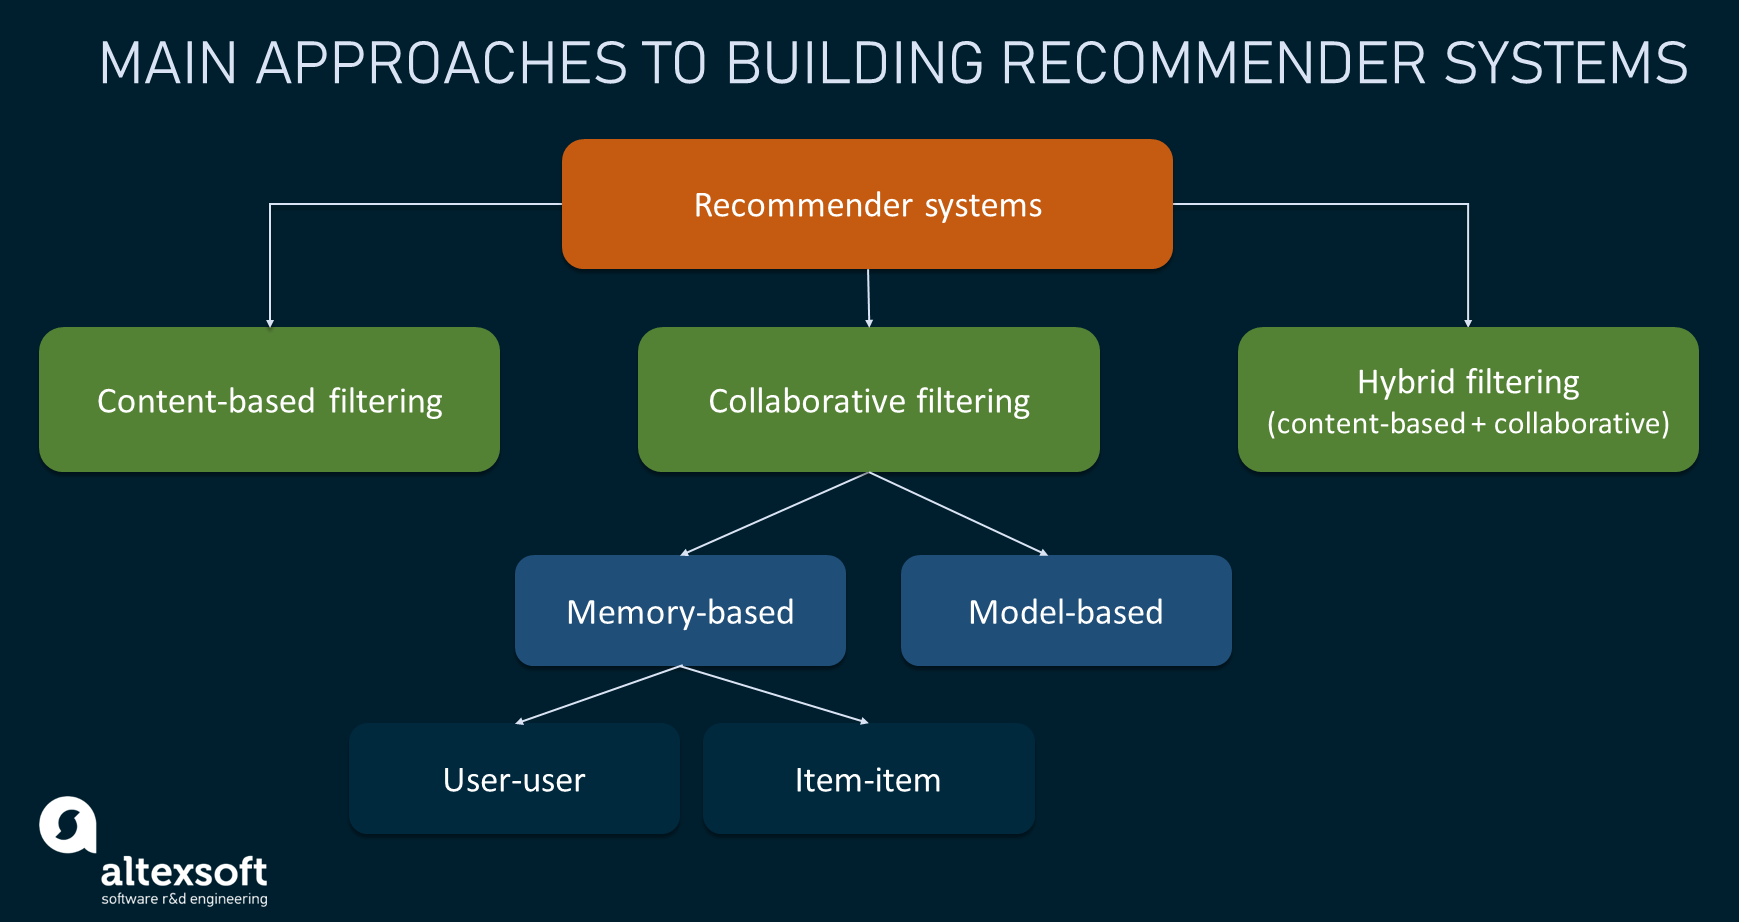

In [75]:
import pandas as pd 
import re 
import numpy as np 
import nltk
from string import punctuation
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
import pickle
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# <strong> Filter important features and labels

In [112]:
df = pd.read_csv('C:\\Users\\User\Desktop\\Job-recommendation-system-\\backend\\recommender\\resume.csv')
print(df.Category.unique())
important_category = ['Data Science', 'HR', 'Web Designing', 'Java Developer', 'Python Developer', 'Electrical Engineering', 'Database','Network Security Engineer','Testing', 'Business Analyst']
df = df[df.Category.map(lambda x:x in important_category)]


['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


# Step 1: <strong>Preporcessing</strong> stage. 

In [113]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s0-9]' % re.escape(punctuation), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    resumeText = re.sub(r'\b\w\b', '', resumeText)
    return resumeText
# Map the resume to clean the text 
df.Resume = df.Resume.map(cleanResume)

<!-- Linear Model $\hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j} $ -->

# Step 2: <strong>Remove stop words                                 

Stop words are basically a set of commonly used words in any language, not just English.<br>The reason why stop words are critical to many applications is that, if we remove the words <br>that are very commonly used in a given language, we can focus on the important words instead.

Stop words can be used in a whole range of tasks and here are a few:

1. <strong>Supervised machine learning</strong> – removing stop words from the feature space<br>
2. <strong>Clustering </strong>– removing stop words prior to generating clusters<br>
3. <strong> Information retrieval </strong> – preventing stop words from being indexed<br>
4. <strong> Text summarization </strong>- excluding stop words from contributing to summarization scores & removing stop words when computing ROUGE scores<br>

# Step 3: <strong> Word vectorizer using TfidfVectorizer 

# <strong>What is TF-IDF?</strong><br>
<strong>Term Frequency - Inverse Document Frequency (TF-IDF)</strong> is a widely used statistical method in natural language processing and information retrieval. It measures how important a term is within a document relative to a collection of documents (i.e., relative to a corpus). Words within a text document are transformed into importance numbers by a text vectorization process. There are many different text vectorization scoring schemes, with TF-IDF being one of the most common.

As its name implies, <br> <strong>TF-IDF vectorizes </strong>/scores  <br>a word by multiplying the word’s Term Frequency (TF) with the Inverse Document Frequency (IDF).

<b>Term Frequency: </b> <br>TF of a term or word is the number of times the term appears in a document compared to the total number of words in the document.


<b>Inverse Document Frequency: </b> <br>IDF of a term reflects the proportion of documents in the corpus that contain the term. Words unique to a small percentage of documents (e.g., technical jargon terms) receive higher importance values than words common across all documents (e.g., a, the, and).

# <strong> TFIDF = TF * IDF  <br>Numerical Example </strong><br>
Imagine the term 
 appears 20 times in a document that contains a total of 100 words. <br> <strong>Term Frequency (TF) of 
 can be calculated as follow:</strong><br> Assume a collection of related documents contains 10,000 documents. <br>If 100 documents out of 10,000 documents contain the term 
, Inverse Document Frequency (IDF) of 
 can be calculated as follows
<br> $  TF= \frac{20}{100} = 0.2 $ <br> $ IDF = log \frac{10000}{100} = 2 $

<br> $ \textit{TF-IDF} = 0.2 * 2 = 0.4 $

In [114]:
stopwords_list = stopwords.words('english')
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     max_features=5000,
                     stop_words=stopwords_list)

In [115]:
sequences = [resume for resume in df.Resume.values]
labels = [label for label in df.Category.values]
vectorizer.fit(sequences)

TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

# Step 4: <strong>Transform the documents into respective vector representations

In [116]:
vector_form = vectorizer.transform(sequences)
category = df.Category.unique()
# Category to index mapping
map_index = {catego:index for index, catego in enumerate(category)}
# Index to category mapping 
hashmap = {index:catego for index, catego in enumerate(category)}
df['Category'] = df.Category.map(map_index)


In [117]:
y = df.Category.values
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

# step 5: <strong>Model training

$\mathbf{\text{RandomForest Classifier}}$ <hr><br>The Random forest classifier creates a set of decision trees from a randomly selected subset of the training set. <br>It is basically a set of decision trees (DT) from a randomly selected subset of the training set and then It collects<br> the votes from different decision trees to decide the final prediction.

In [118]:
# Split the data into train and test data
x_train, x_test, y_train, y_test = train_test_split(vector_form, y, test_size = 20, random_state=0)
# RandomForest classifier
model = RandomForestClassifier(n_estimators = 10, 
                               criterion = 'entropy', 
                               min_samples_split = 2,
                               max_features = 'log2'
                               )

model.fit(x_train, y_train)
x_train.toarray()[-10:]
# To not store all of such like sparse matrix, we have used csr_matrix to compress them down
# model.predict(x_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Step 6: <strong> Save the model weights

<strong>The term model weights is used to describe the components comprising a model.</strong><br>
<strong> ML model Weights: </strong> weights are the real values that are attached with each input/feature <br> and <strong>they convey the importance of that corresponding feature in predicting the final output.

In [119]:
with open('./saved_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Step 7: <strong> Model prediction using saved model weights

We can use Pickle or joblib for loading the saved model here. We are using Pickle model here.

In [120]:
with open('./saved_model.pkl', 'rb') as file:
    model = pickle.load(file)
model.predict(x_test)

array([8, 9, 6, 9, 3, 8, 0, 7, 8, 2, 9, 1, 6, 4, 9, 0, 2, 0, 0, 5],
      dtype=int64)

### Save the index to category mapping for latter use in the prediction. <br> This is important because <strong>computers understand only numbers.

In [121]:
with open('./hashmap.pkl', 'wb') as file:
    pickle.dump(hashmap, file)


### Load the mapping Map to label the predicted values 

In [122]:
with open('./hashmap.pkl', 'rb') as file:
    hashmap = pickle.load(file)
hashmap

{0: 'Data Science',
 1: 'HR',
 2: 'Web Designing',
 3: 'Java Developer',
 4: 'Business Analyst',
 5: 'Electrical Engineering',
 6: 'Python Developer',
 7: 'Network Security Engineer',
 8: 'Database',
 9: 'Testing'}

## Save the text vectorizer.

In [123]:
# with open('./vectorizer.pkl', 'wb') as file:
#     pickle.dump(vectorizer, file)


In [124]:
# with open('./vectorizer.pkl', 'rb') as file:
#     vectorizer = pickle.load(file)
# vectorizer.get_feature_names

<bound method CountVectorizer.get_feature_names of TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])>

In [125]:
# Find the label of the predict value
hashmap[0]

'Data Science'

In [126]:
# All the index to category mapping.
hashmap

{0: 'Data Science',
 1: 'HR',
 2: 'Web Designing',
 3: 'Java Developer',
 4: 'Business Analyst',
 5: 'Electrical Engineering',
 6: 'Python Developer',
 7: 'Network Security Engineer',
 8: 'Database',
 9: 'Testing'}

#### <strong>Predict the category of a random job description from Linkedin Post. Which is a data science job. 

In [127]:
text = """
Bachelor's Degree in a Computer Science or related technical discipline, preferred but not required 
10+ years of experience with Java, HTML (HTML5), CSS, JavaScript, JSON, PL SQL, Eclipse, (Subversion or GitHub) 
Must be able to obtain a Position of Public Trust Clearance
US Citizen or Permanent Resident (Green Card Holder)
The security clearance for this program requires the selected candidate to have resided in the US for the past five years. The selected candidate cannot have left the country for longer than 90 consecutive days and no more than 180 cumulative days. 
Bachelor's Degree in a Computer Science or related technical discipline, preferred but not required
10+ years of experience with Java, HTML(HTML5), CSS, JavaScript, JSON, PL SQL, Eclipse, Subversion or GitHub
Knowledge/experience with Agile Methodologies"""

In [128]:
# Clean the text
cleaned_text = cleanResume(text)
cleaned_text

' Bachelor  Degree in  Computer Science or related technical discipline preferred but not required years of experience with Java HTML HTML CSS JavaScript JSON PL SQL Eclipse Subversion or GitHub Must be able to obtain  Position of Public Trust Clearance US Citizen or Permanent Resident Green Card Holder The security clearance for this program requires the selected candidate to have resided in the US for the past five years The selected candidate cannot have left the country for longer than consecutive days and no more than cumulative days Bachelor  Degree in  Computer Science or related technical discipline preferred but not required years of experience with Java HTML HTML CSS JavaScript JSON PL SQL Eclipse Subversion or GitHub Knowledge experience with Agile Methodologies'

In [129]:
# Convert the text to numpy array and reshape it.
# vec_text = np.array(text).reshape(1,)
# vector_form = vectorizer.transform(vec_text)

In [130]:
# model.predict(vector_form)

# <strong>Put all them together 

In [80]:
class Classifier:
    def __init__(self, 
                n_estimators = 10, 
                criterion = 'entropy',
                min_samples_split = 2,
                max_features = 'log2'):
        
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.min_samples_split = min_samples_split
        self.max_features = max_features
    def __call__(self):
        model = RandomForestClassifier(n_estimators = self.n_estimators, criterion = self.criterion, max_features = self.max_features)
        return model
    def save_weights(self, path, model):
        with open(path, 'wb') as file:
            pickle.dump(model, file)

class Preprocessor:
    def __init__(self, description) -> None:
        self.cleaned_text = np.array(self.cleanResume(description)).reshape(1,)
        self.category = self.predictor()
    def cleanResume(self, resumeText):
        resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
        resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
        resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
        resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
        resumeText = re.sub('[%s0-9]' % re.escape(punctuation), ' ', resumeText)  # remove punctuations
        resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
        resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
        resumeText = re.sub(r'\b\w\b', '', resumeText)
        return resumeText
    
    def predictor(self):
        with open('./vectorizer.pkl', 'rb') as file:
            vectorizer = pickle.load(file)
        with open('./saved_model.pkl', 'rb') as file:
            model = pickle.load(file)
        with open('./hashmap.pkl', 'rb') as file:
            hashmap = pickle.load(file)        
            
        sequence = self.cleaned_text
        vector_form = vectorizer.transform(sequence)
        class_type = model.predict(vector_form)
        return hashmap[class_type[0]]


In [81]:
clf = Classifier()
model = clf.__call__()
model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=10)

In [82]:
model.predict(x_test)

array([8, 9, 6, 9, 3, 8, 0, 7, 8, 2, 9, 1, 6, 4, 9, 0, 2, 0, 0, 5],
      dtype=int64)

In [83]:
model_path = './saved_model.pkl'
vectorizer_path = './vectorizer.pkl'
hashmap_path = './hashmap.pkl'
clf.save_weights(model_path, model)
clf.save_weights(vectorizer_path, vectorizer)
clf.save_weights(hashmap_path, hashmap)

In [84]:
description = """
Bachelor's Degree in a Computer Science or related technical discipline, preferred but not required 
10+ years of experience with Java, HTML (HTML5), CSS, JavaScript, JSON, PL SQL, Eclipse, (Subversion or GitHub) 
Must be able to obtain a Position of Public Trust Clearance
US Citizen or Permanent Resident (Green Card Holder)
The security clearance for this program requires the selected candidate to have resided in the US for the past five years. The selected candidate cannot have left the country for longer than 90 consecutive days and no more than 180 cumulative days. 
Bachelor's Degree in a Computer Science or related technical discipline, preferred but not required
10+ years of experience with Java, HTML(HTML5), CSS, JavaScript, JSON, PL SQL, Eclipse, Subversion or GitHub
Knowledge/experience with Agile Methodologies

""" 

In [86]:
preprocessor = Preprocessor(description)
preprocessor.category

'Java Developer'

# Among all those similarity measures, we are using Cosine similariry<br>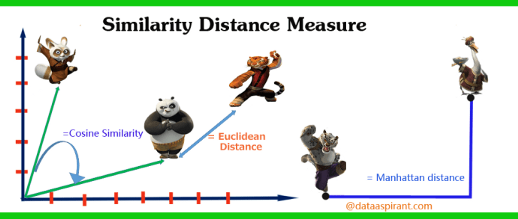

In [ ]:
def similarity(text1, text2):
    document = [text1, text2]
    tfidf = TfidfVectorizer()
    vector = tfidf.fit_transform(document)
    document_similarity = cosine_similarity(vector)
    return document_similarity[0][1]

In [88]:
resumes = ["An aspring software engineer who had lots of experiences in Machine learning",
           "A web designer in silicon valley companies",
           "An aspring software engineer who had lots of experiences in Machine learning We are hiring talents who have at least 3 years of experience as",
           "A web designer in silicon valley companies a software engineer and less than one years of experience in machine learning",
           "An aspring software engineer who had lots of experiences in Machine learning  and database management systme specialist at Bloomburge",
           "An aspring software engineer who had lots of experiences in Machine learning  and project management system specialist at Google"
           ]
job_description = [""" We are hiring talents who have at least 3 years of experience as 
                   a software engineer and less than one years of experience in machine learning
                   """]

In [89]:
resumes_vec = vectorizer.transform(resumes)
job_description_vec = vectorizer.transform(job_description)

In [90]:
resumes_vec.toarray()[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
# The categories of the classification
job_description_vec.toarray()[:10] 

array([[0., 0., 0., ..., 0., 0., 0.]])

Find the similarity metrics for each resume in resumes with respect to the job description

In [92]:
probability = []
for resume in resumes:
    probability.append((similarity(resume, description)))

# Rank the top resumes by using cosine similarity
top_resumes_indeces = np.argsort(probability)
print(probability)
print(top_resumes_indeces)

[0.05632147266239576, 0.03949442586773029, 0.11027502367637908, 0.14532151931655873, 0.052145701729846616, 0.052145701729846616]
[1 4 5 0 2 3]


In [141]:
for top_resume_index in top_resumes_indeces:
    print(hashmap[top_resume_index])

HR
Business Analyst
Electrical Engineering
Data Science
Web Designing
Java Developer


# <strong>Evaluation</strong> <br>
Evaluation is important for machine learning projects, because it allows to compare objectivelly different algorithms and hyperparameter choices for models. One key aspect of evaluation is to ensure that the trained model generalizes for data it was not trained on, using Cross-validation techniques. We are using here a simple cross-validation approach named holdout, in which a random data sample (20% in this case) are kept aside in the training process, and exclusively used for evaluation. All evaluation metrics reported here are computed using the test set.

Ps. A more robust evaluation approach could be to split train and test sets by a reference date, where the train set is composed by all interactions before that date, and the test set are interactions after that date. For the sake of simplicity, we chose the first random approach for this notebook, but you may want to try the second approach to better simulate how the recsys would perform in production predicting "future" users interactions.

# <strong>Evaluation will continue here 